# Analysis of test set results for AMP Conference
TODO

In [ ]:
from collections import defaultdict
import json
from pathlib import Path
import regex as re

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd
import seaborn as sns

sns.color_palette("colorblind")
font = {"size": 16}
matplotlib.rc("font", **font)


In [2]:
plt.rcParams["figure.figsize"] = (12, 12)
EVAL_PATH = Path("../data/evaluation_results/detailed_predictions/")
TRAINED_MODEL_PATH = Path("../data/models/")

# Results from external baselines
EXTERNAL_PREDICTION_CSVS = [
    EVAL_PATH
    / "elgeish_wav2vec2-large-lv60-timit-asr_to_epitran_detailed_predictions.csv",
    EVAL_PATH / "allosaurus_eng2102_ipa_detailed_predictions.csv",
    EVAL_PATH
    / "ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa-plus-2000_detailed_predictions.csv",
    EVAL_PATH / "facebook_wav2vec2-lv-60-espeak-cv-ft_detailed_predictions.csv",
    EVAL_PATH / "facebook_wav2vec2-xlsr-53-espeak-cv-ft_detailed_predictions.csv",
    EVAL_PATH / "openai_whisper-large-v3_to_epitran_detailed_predictions.csv",
    EVAL_PATH / "openai_whisper-large-v3-turbo_to_epitran_detailed_predictions.csv",
    EVAL_PATH / "openai_whisper-medium-en_to_epitran_detailed_predictions.csv",
]
EXTERNAL_NAME_PATTERN = re.compile(r"[\w-]+(?=_detailed_predictions.csv)")

EXPERIMENT_PREDICTION_CSVS = list(
    EVAL_PATH.glob("data_models_*_detailed_predictions.csv")
)
# Use to pull the experiment name and number id from the file name
EXP_NAME_PATTERN = re.compile(
    r"(?<=data_models_)[\w-]+(?=_wav2vec2-large-xlsr-53-buckeye-ipa_detailed_predictions.csv)"
)

In [3]:
def get_experiment_label(full_exp_name, pattern):
    """Parse out the experiment label from the file name
    Experiment label are some brief description (\w chars) followed by _ and a single digit

    Args:
        full_exp_name (str): Filename for experiment results, starts with 'data_model_" followed by the experiment label and ends with "_detailed_predictions.csv"

    Returns:
        str: full experiment label
    """
    experiment_id = pattern.search(full_exp_name)
    return experiment_id.group(0)

In [4]:
# Combine all CSV together
exp_group_display_key = "Experiment group"

all_dataframes = []
for csv in EXPERIMENT_PREDICTION_CSVS:
    dataframe = pd.read_csv(csv, index_col=False)
    experiment_label = get_experiment_label(csv.name, EXP_NAME_PATTERN)
    experiment_group = experiment_label[:-2]
    experiment_id = experiment_label[-1:]
    dataframe["experiment_label"] = experiment_label
    dataframe["experiment_group"] = experiment_group
    dataframe["experiment_id"] = experiment_id
    if experiment_group.startswith("data_seed") or experiment_group == "hyperparam_tuning":
        dataframe[exp_group_display_key] = "Our AutoIPA: balanced gender"
    elif experiment_group.startswith("gender_split_30_female"):
        dataframe[exp_group_display_key] = "Our AutoIPA: biased male"
    elif experiment_group.startswith("gender_split_70_female"):
        dataframe[exp_group_display_key] = "Our AutoIPA: biased female"
    elif experiment_group.startswith("vary_individuals_young_only"):
        dataframe[exp_group_display_key] = "Our AutoIPA: biased young"
    elif experiment_group.startswith("vary_individuals_old_only"):
        dataframe[exp_group_display_key] = "Our AutoIPA: biased old"
    dataframe["Model source"] = "Our AutoIPA"
    all_dataframes.append(dataframe)


for csv in EXTERNAL_PREDICTION_CSVS:
    dataframe = pd.read_csv(csv, index_col=False)
    experiment_label = get_experiment_label(csv.name, EXTERNAL_NAME_PATTERN)
    experiment_group = experiment_label
    experiment_id = 1
    print(csv.name, "Label:", experiment_label, "Group:", experiment_group, "Experiment id:", experiment_id)
    dataframe["experiment_label"] = experiment_label
    dataframe["experiment_group"] = experiment_group
    dataframe["experiment_id"] = experiment_id
    if experiment_label.startswith("allosaurus"):
        dataframe[exp_group_display_key] = "Allosaurus English"
        dataframe["Model source"] = "Allosaurus English"
    elif "whisper" in experiment_label:
        dataframe[exp_group_display_key] = "Whisper + Grapheme2Phoneme"
        dataframe["Model source"] = "Whisper + Grapheme2Phoneme"
    else:
        dataframe[exp_group_display_key] = "Wav2Vec2.0 + Grapheme2Phoneme"
        dataframe["Model source"] = "Wav2Vec2.0 + Grapheme2Phoneme"

    all_dataframes.append(dataframe)

all_data = pd.concat(all_dataframes)
all_data.head()



elgeish_wav2vec2-large-lv60-timit-asr_to_epitran_detailed_predictions.csv Label: elgeish_wav2vec2-large-lv60-timit-asr_to_epitran Group: elgeish_wav2vec2-large-lv60-timit-asr_to_epitran Experiment id: 1
allosaurus_eng2102_ipa_detailed_predictions.csv Label: allosaurus_eng2102_ipa Group: allosaurus_eng2102_ipa Experiment id: 1
ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa-plus-2000_detailed_predictions.csv Label: ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa-plus-2000 Group: ctaguchi_wav2vec2-large-xlsr-japlmthufielta-ipa-plus-2000 Experiment id: 1
facebook_wav2vec2-lv-60-espeak-cv-ft_detailed_predictions.csv Label: facebook_wav2vec2-lv-60-espeak-cv-ft Group: facebook_wav2vec2-lv-60-espeak-cv-ft Experiment id: 1
facebook_wav2vec2-xlsr-53-espeak-cv-ft_detailed_predictions.csv Label: facebook_wav2vec2-xlsr-53-espeak-cv-ft Group: facebook_wav2vec2-xlsr-53-espeak-cv-ft Experiment id: 1
openai_whisper-large-v3_to_epitran_detailed_predictions.csv Label: openai_whisper-large-v3_to_epitran 

,utterance_id,duration,buckeye_transcript,text,ipa,speaker_id,speaker_gender,speaker_age_range,interviewer_gender,file_path,prediction,phone_error_rates,phone_feature_error_rates,feature_error_rates,experiment_label,experiment_group,experiment_id,Experiment group,Model source
0,s2501a_Utt0,0.925981,f ao r f ay v,four five,fɔɹfaɪv,S25,f,o,m,data/buckeye/test/s2501a_Utt0.wav,θɔɹfaɪv,0.142857,0.166667,0.017857,data_seed_bs64_1,data_seed_bs64,1,Our AutoIPA: balanced gender,Our AutoIPA
1,s2501a_Utt1,13.394466,U uw ah nx ay hh ey tq hh iy r ih n m ay s eh ...,EXCLUDE-four_five_six_seven_eight_nine_ten_ele...,uʌɾ̃aɪheɪʔhiɹɪnmaɪsɛlfɑn,S25,f,o,m,data/buckeye/test/s2501a_Utt1.wav,uɛɾ̃aɪheɪʔhiɹɪnmaɪsɛlfɑnɪɡ,0.130435,2.083333,0.003623,data_seed_bs64_1,data_seed_bs64,1,Our AutoIPA: balanced gender,Our AutoIPA
2,s2501a_Utt10,0.325586,y eh s,yes,jɛs,S25,f,o,m,data/buckeye/test/s2501a_Utt10.wav,jɛs,0.000000,0.000000,0.000000,data_seed_bs64_1,data_seed_bs64,1,Our AutoIPA: balanced gender,Our AutoIPA
3,s2501a_Utt100,0.304521,em hh em,um-hum,m̩hm̩,S25,f,o,m,data/buckeye/test/s2501a_Utt100.wav,m̩hm̩,0.000000,0.000000,0.000000,data_seed_bs64_1,data_seed_bs64,1,Our AutoIPA: balanced gender,Our AutoIPA
4,s2501a_Utt101,0.792904,ah m th ah w ah,um the well,ʌmθʌwʌ,S25,f,o,m,data/buckeye/test/s2501a_Utt101.wav,ʌmθwl,0.333333,1.333333,0.093750,data_seed_bs64_1,data_seed_bs64,1,Our AutoIPA: balanced gender,Our AutoIPA


# Overall model performance in aggregate
This section collects the test set performance results form all models to compare. 

The metrics we are using to measure model performance are described as follows and lower values indicate better performance for all of them: 
- **phone error rate**: Phone error rate (PER) gives edit distance in terms of phones for each prediction-reference pair, rather than Unicode characters, since phones can consist of multiple characters. It is normalized by the number of phones of the reference string. The result will have the same length as the input prediction and reference lists.
- **phone feature error rate**: Phone feature error rate (PFER) is Levenshtein distance between strings where distance between individual phones is computed using Hamming distance between phonetic features for each prediction-reference pair. By default it is a metric that obeys the triangle equality, but can also be normalized by number of phones.
- **feature error rate**: Feature error rate (FER) is the edit distance in terms of articulatory features normalized by the number of phones in the reference, computed for each prediction-reference pair.

## Summary of results
- All the models we've trained on Buckeye data perform better than external baselines, which include the [best model](https://huggingface.co/ctaguchi/wav2vec2-large-xlsr-japlmthufielta-ipa-plus-2000) from the [Taguchi paper](http://arxiv.org/pdf/2308.03917), [Allosaurus](https://github.com/xinjli/allosaurus), and passing wav2vec2 output to the [Epitran](https://github.com/dmort27/epitran) grapheme to phoneme library. This is fairly unsurprising, given that we've fine-tuned our models on data that is more similar to the test set. However, it does demonstrate the benefit of fine-tuning in situations where low error rates are critically important. 
- There is little difference between the performance of our models, despite variation in the make up of training data. 

In [5]:
# Overall best models by mean phone error rate
overall_means = all_data.groupby(["experiment_label", exp_group_display_key, "Model source"])[["phone_error_rates", "phone_feature_error_rates", "feature_error_rates"]].mean().reset_index().sort_values(by="phone_error_rates")
display(overall_means)

,experiment_label,Experiment group,Model source,phone_error_rates,phone_feature_error_rates,feature_error_rates
15,gender_split_70_female_2,Our AutoIPA: biased female,Our AutoIPA,0.276478,4.231386,0.164055
5,data_seed_bs64_4,Our AutoIPA: balanced gender,Our AutoIPA,0.282574,4.282405,0.165328
4,data_seed_bs64_3,Our AutoIPA: balanced gender,Our AutoIPA,0.285728,4.317492,0.167423
19,hyperparam_tuning_1,Our AutoIPA: balanced gender,Our AutoIPA,0.286054,4.313948,0.167077
14,gender_split_70_female_1,Our AutoIPA: biased female,Our AutoIPA,0.286303,4.366919,0.166622
12,gender_split_30_female_4,Our AutoIPA: biased male,Our AutoIPA,0.287317,4.390759,0.167159
2,data_seed_bs64_1,Our AutoIPA: balanced gender,Our AutoIPA,0.287559,4.384820,0.165525
23,vary_individuals_old_only_1,Our AutoIPA: biased old,Our AutoIPA,0.289996,4.449367,0.166510
16,gender_split_70_female_3,Our AutoIPA: biased female,Our AutoIPA,0.291484,4.339412,0.168314
3,data_seed_bs64_2,Our AutoIPA: balanced gender,Our AutoIPA,0.291753,4.502666,0.167820


In [6]:
model_type_means = (
    all_data.groupby([exp_group_display_key, "Model source"])[
        ["phone_error_rates", "phone_feature_error_rates", "feature_error_rates"]
    ]
    .mean()
    .reset_index()
    .sort_values(by="phone_error_rates")
)
display(model_type_means)


,Experiment group,Model source,phone_error_rates,phone_feature_error_rates,feature_error_rates
1,Our AutoIPA: balanced gender,Our AutoIPA,0.286734,4.360266,0.166634
2,Our AutoIPA: biased female,Our AutoIPA,0.292399,4.402909,0.166525
4,Our AutoIPA: biased old,Our AutoIPA,0.297602,4.465058,0.167044
5,Our AutoIPA: biased young,Our AutoIPA,0.299078,4.449676,0.167108
3,Our AutoIPA: biased male,Our AutoIPA,0.306236,4.517336,0.166410
7,Whisper + Grapheme2Phoneme,Whisper + Grapheme2Phoneme,0.566441,7.771516,0.225120
0,Allosaurus English,Allosaurus English,0.660439,7.608830,0.181840
6,Wav2Vec2.0 + Grapheme2Phoneme,Wav2Vec2.0 + Grapheme2Phoneme,0.687159,7.079941,0.387855


/tmp/ipykernel_3289550/2714364943.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='right')


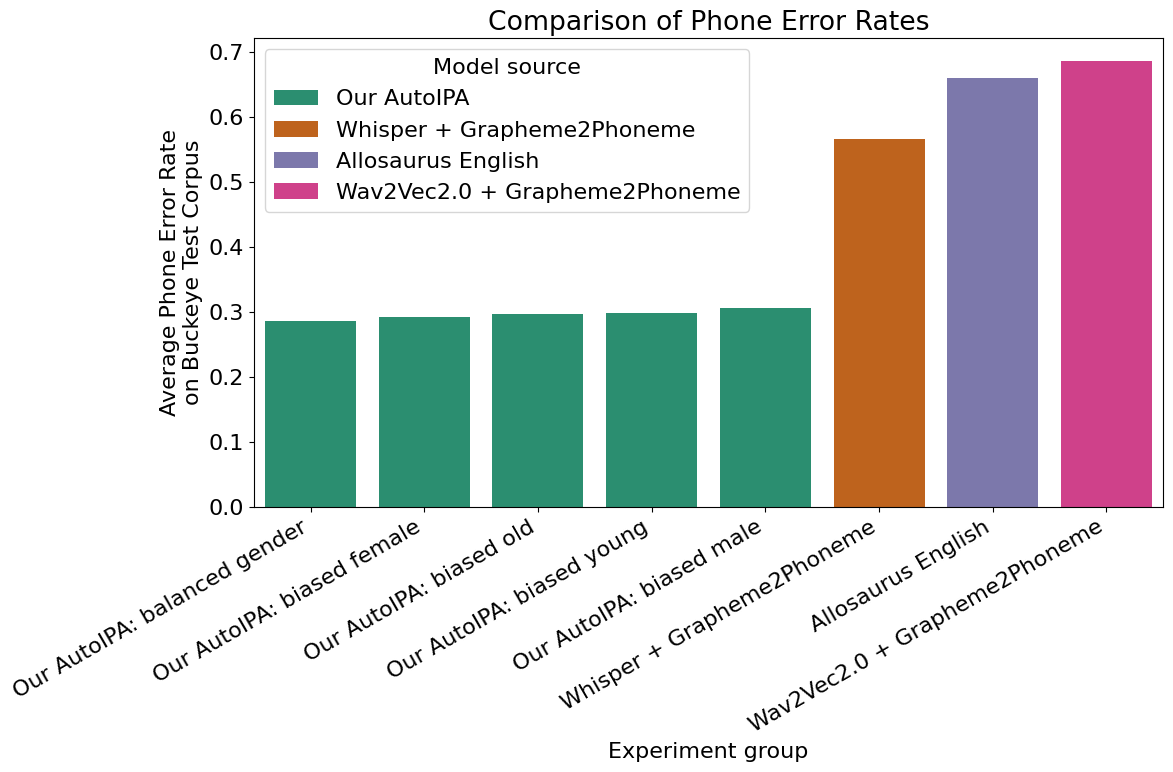

In [7]:
plt.figure(figsize=(12, 8))
g = sns.barplot(data = model_type_means, x=exp_group_display_key, y="phone_error_rates", hue="Model source", palette="Dark2")
g.set_xticklabels(g.get_xticklabels(), rotation=30, horizontalalignment='right')
g.set_title("Comparison of Phone Error Rates")
g.set_ylabel("Average Phone Error Rate\non Buckeye Test Corpus")
plt.tight_layout()


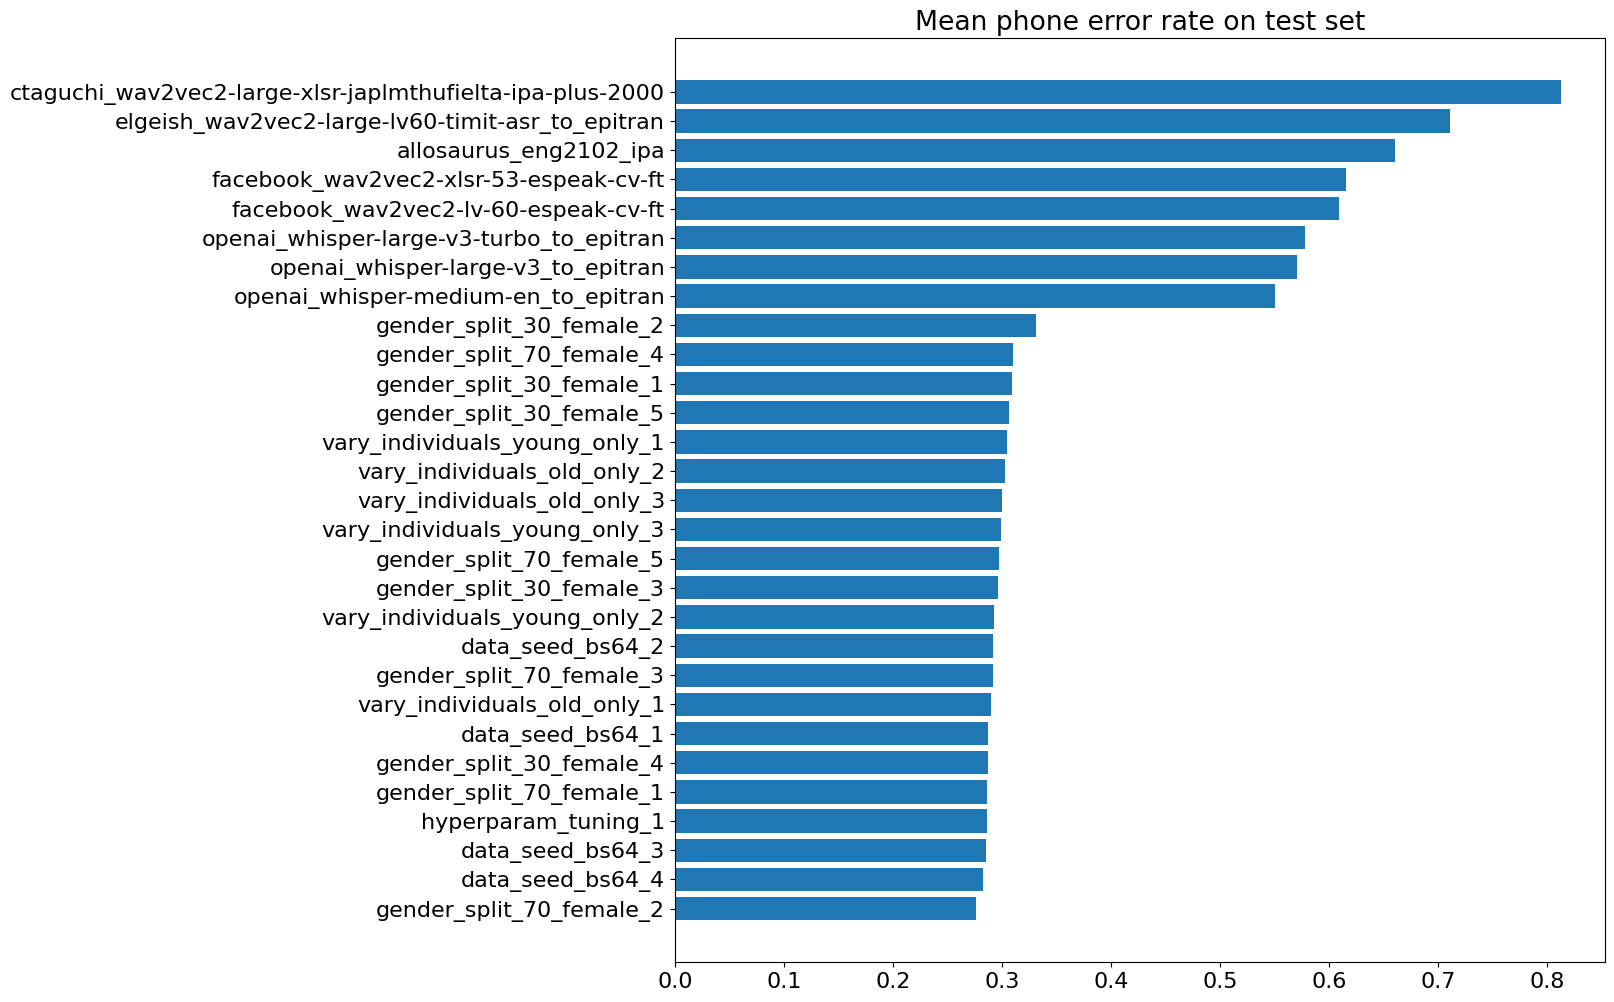

In [8]:
fig, ax = plt.subplots()
ax.barh(overall_means["experiment_label"], overall_means["phone_error_rates"])
_ = ax.set_title("Mean phone error rate on test set")

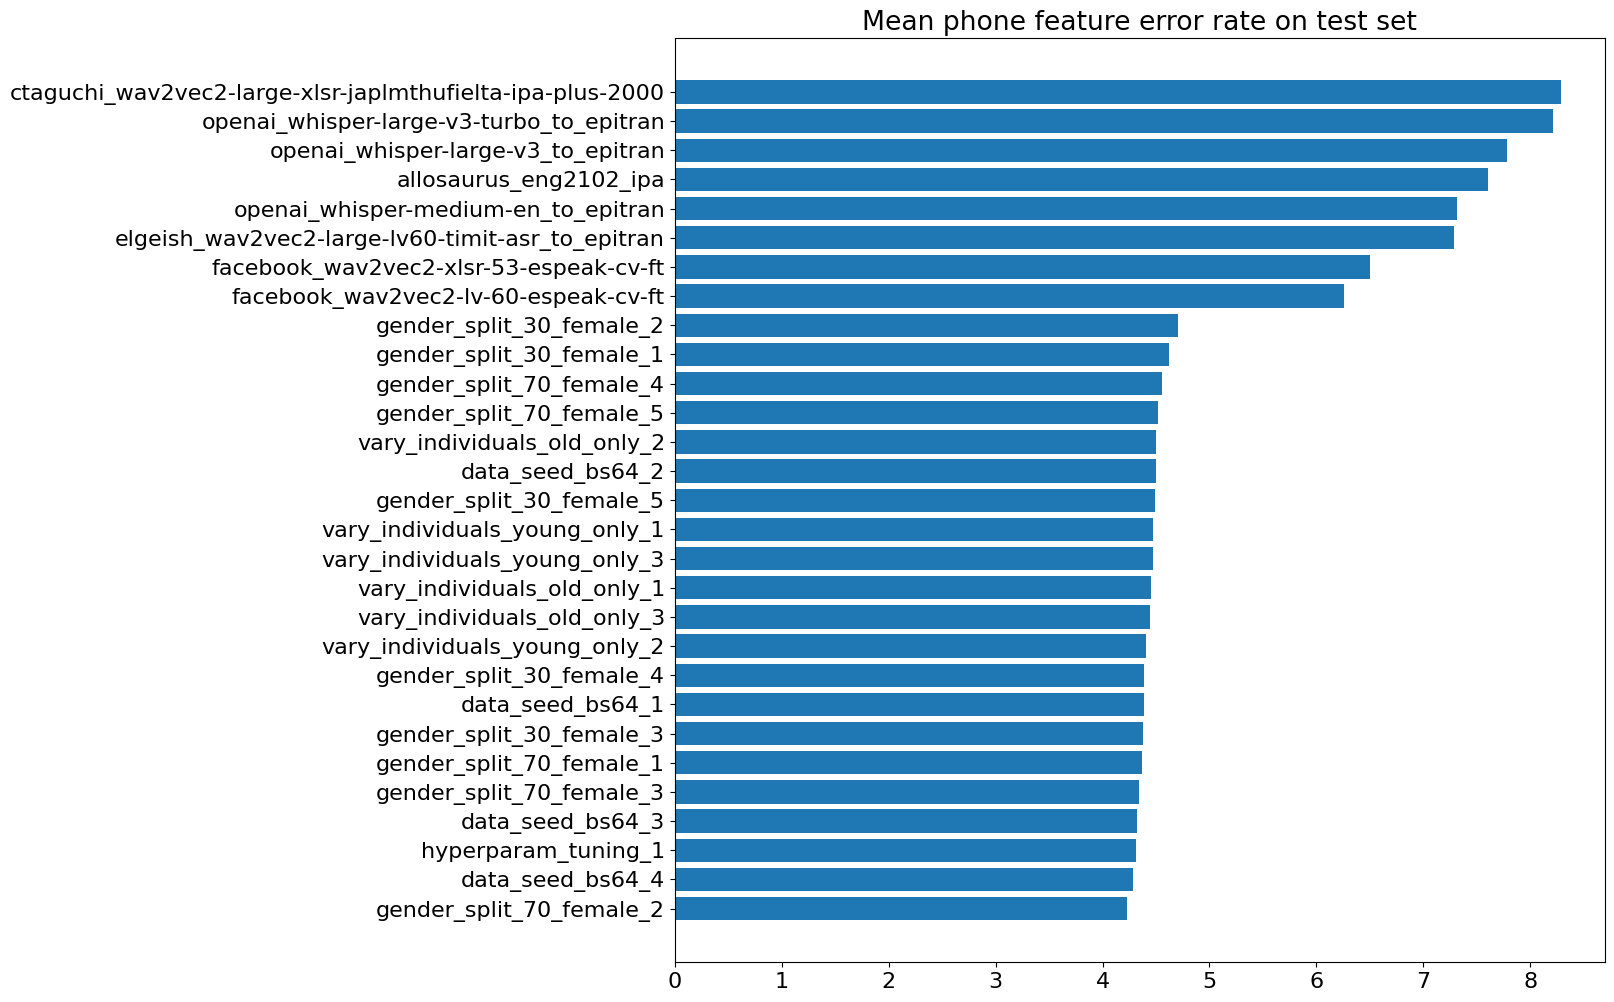

In [9]:
overall_means.sort_values(by="phone_feature_error_rates", inplace=True)
fig, ax = plt.subplots()
ax.barh(overall_means["experiment_label"], overall_means["phone_feature_error_rates"])
_ = ax.set_title("Mean phone feature error rate on test set")

# Differences in performance by gender
This looks at the differences in performance in samples from for male and female speakers in the test set. 
Across the board, the models (both our fine-tuned and the external baselines) perform better on female speakers than male speakers. This is not due to the duration of speakers of a specific gender appearing in the training data, because performance metrics are higher for female speakers even when 70% of training data samples came from male speakers and the duration of training data from male speakers was larger than the duration of training samples from female speakers. 

Note that it is yet unclear whether these performance differences are statistically significance. That requires further discussion of experimental design and desired research goals. 

In [10]:
def stratify_mean_by_experiment_group_and_demographic(dataframe, experiment_label_key = "experiment_label", demo_key="speaker_gender"):
    stratified_metrics = defaultdict(lambda: defaultdict(list)) # e.g. for gender {'m':{'phone_error_rate':[...]}, 'f':{'phone_error_rate':[...]}}
    models = list()
    for name, model_group in dataframe.groupby(experiment_label_key):
        for demo, group in model_group.groupby(demo_key):
            for metric in ["phone_error_rates", "phone_feature_error_rates", "feature_error_rates"]:
                metric_mean = group[metric].mean()
                stratified_metrics[demo][metric].append(metric_mean)
        models.append(name)

    return stratified_metrics, models


In [11]:
gendered_metrics, models = stratify_mean_by_experiment_group_and_demographic(all_data)

In [12]:
# Check that these are all the same length to make sure we parsed data correctly
assert len(gendered_metrics['f']['phone_error_rates']) == len(gendered_metrics['m']['phone_error_rates'])
assert len(gendered_metrics['f']['phone_error_rates']) == len(models)

In [13]:
def plot_binary_category_grouped_metrics(models, category1_results_dict, category2_results_dict, title="Average phone error rate by gender", metric_name ="phone_error_rates",
        category1_label="male speaker", category2_label="female speaker"):
    category1_per = category1_results_dict[metric_name]
    category2_per = category2_results_dict[metric_name]
    assert len(category1_per) == len(models)
    assert len(category2_per) == len(models)

    fig, ax = plt.subplots()
    y = np.arange(len(models))
    width = 0.3
    multiplier = 0

    plt.barh(y-width, category1_per, width)
    plt.barh(y,  category2_per, width)
    plt.yticks(y, models)
    plt.ylabel("experiment label")
    plt.xlabel(metric_name)
    plt.title(title)
    plt.legend([category1_label, category2_label],loc='center left', bbox_to_anchor=(1, 0.5))

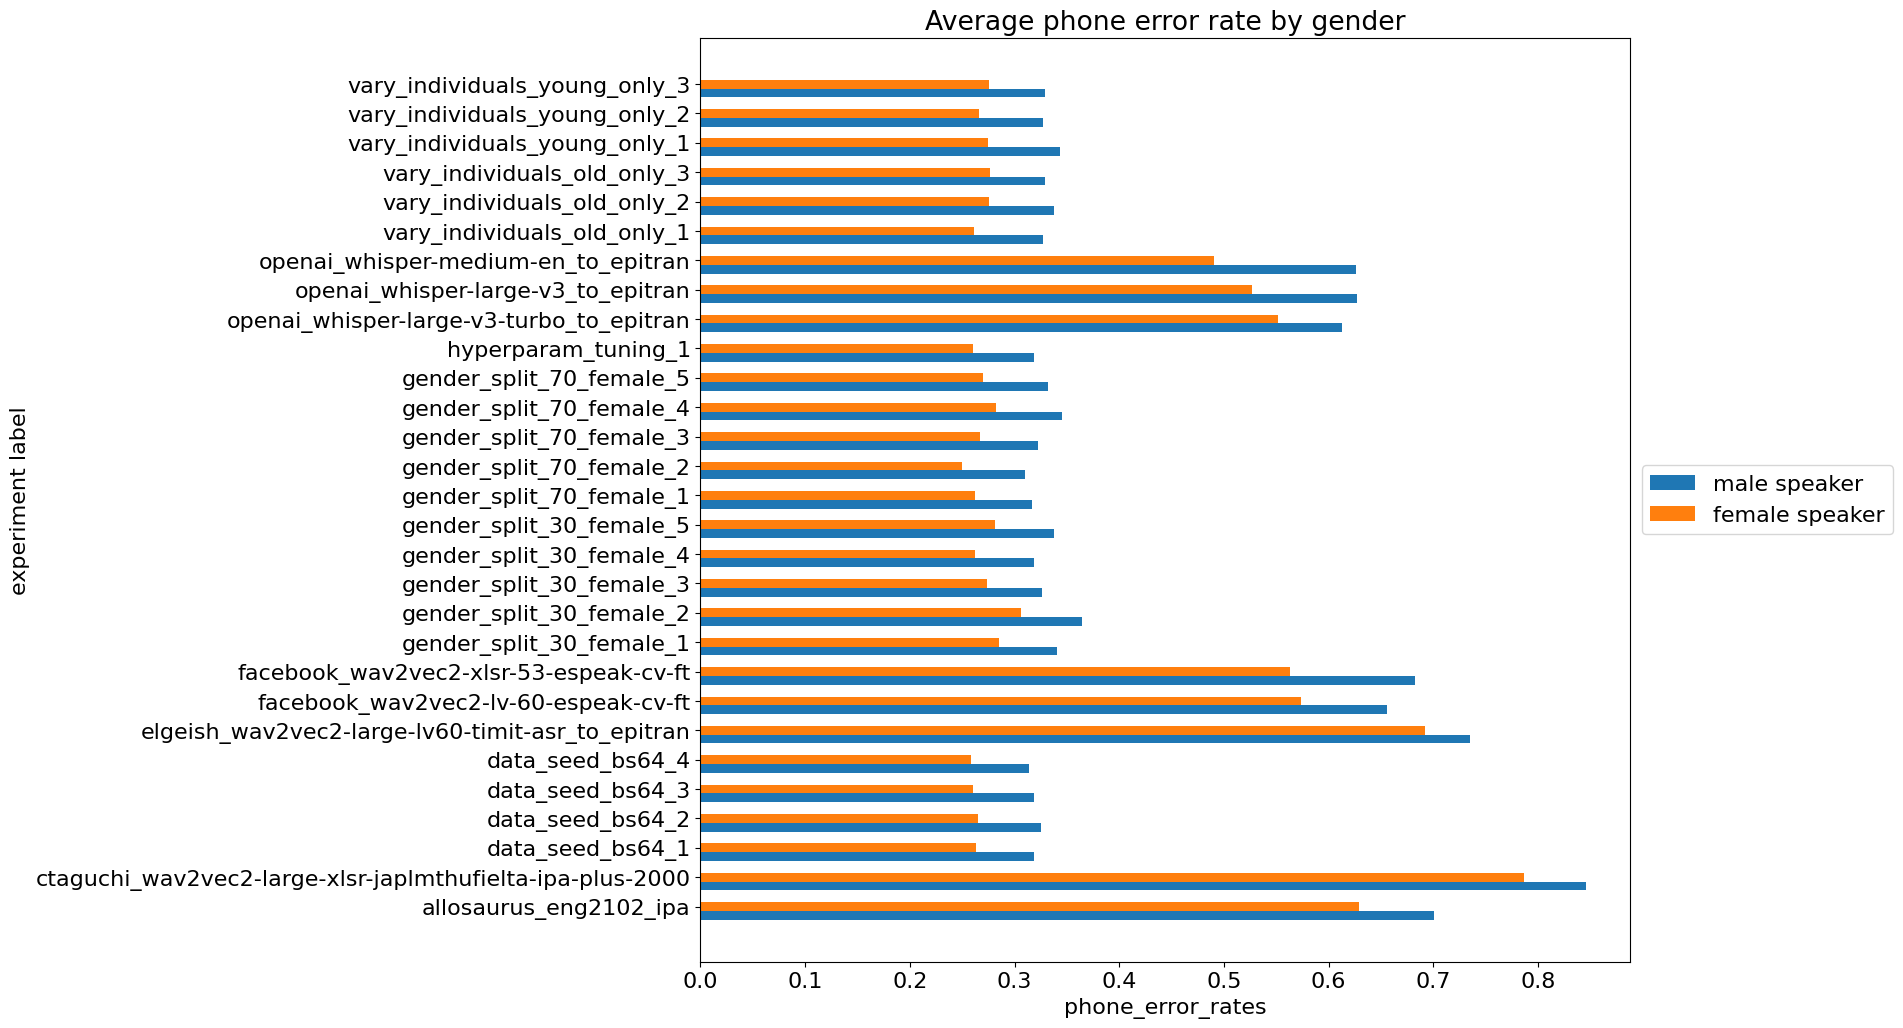

In [14]:
plot_binary_category_grouped_metrics(models, gendered_metrics['m'], gendered_metrics['f'])

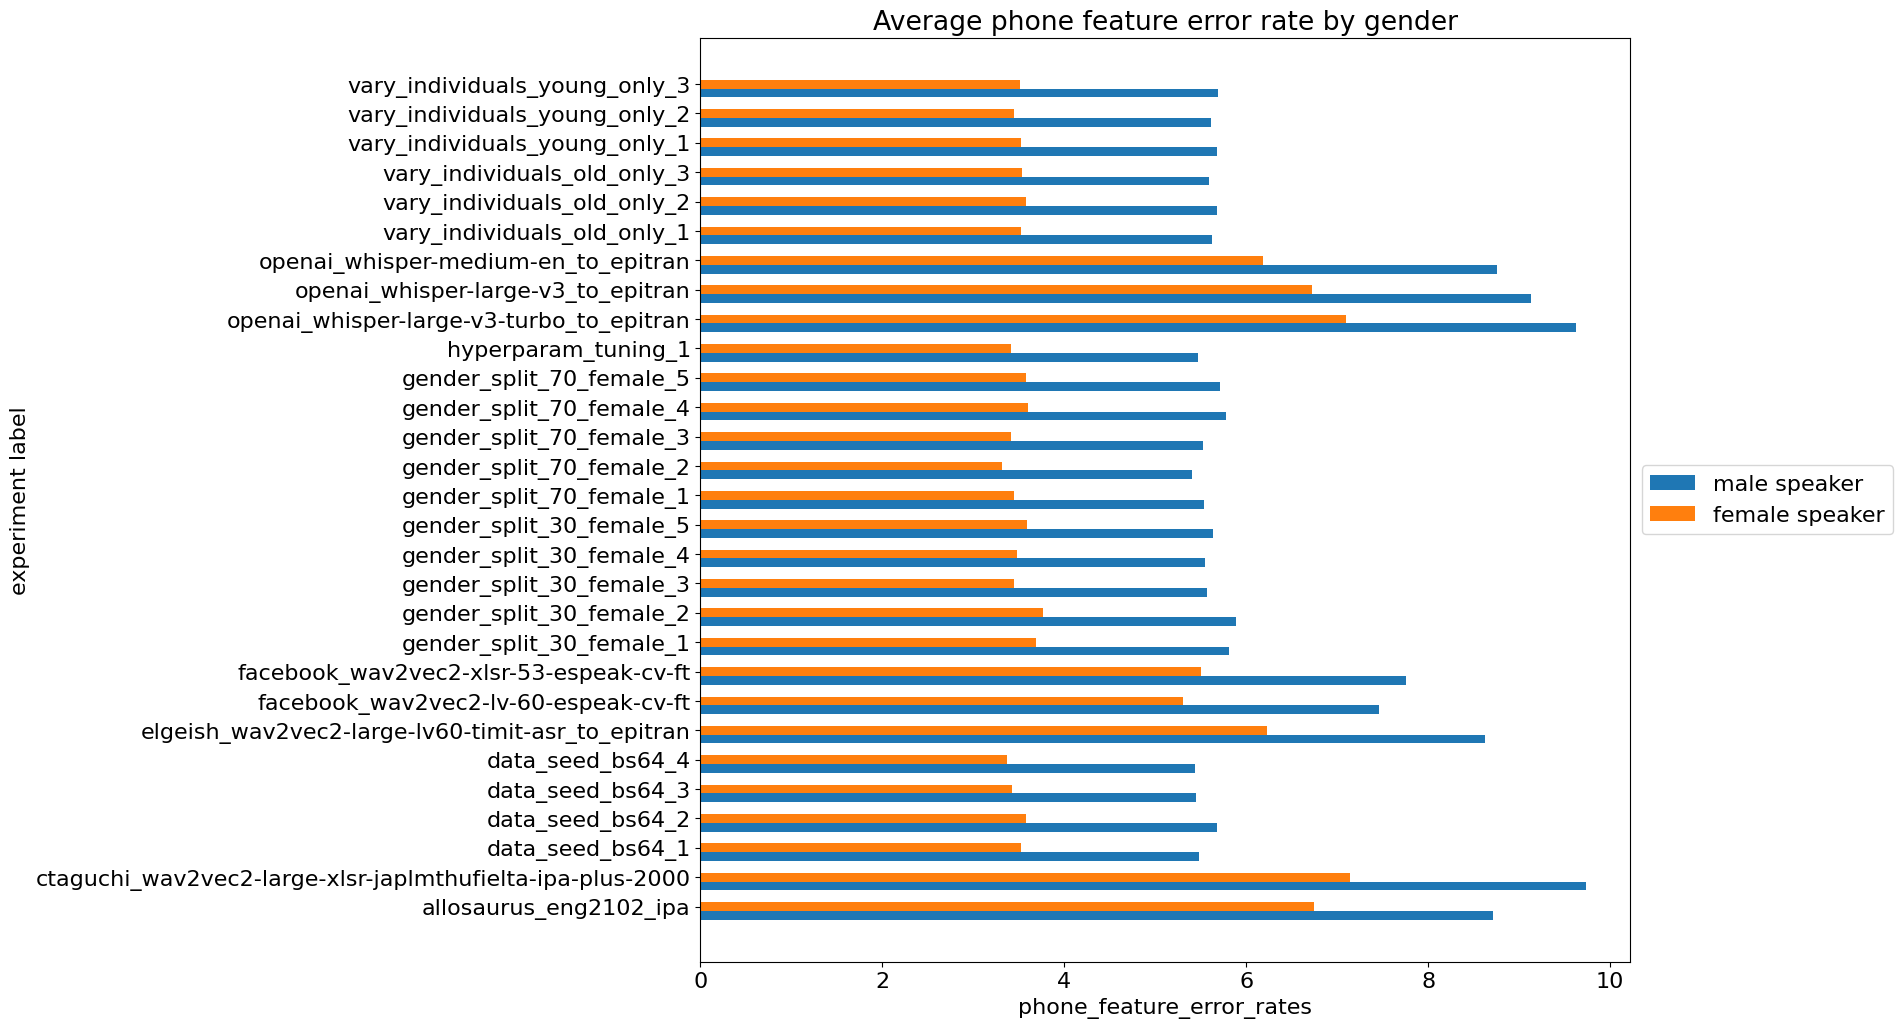

In [15]:
plot_binary_category_grouped_metrics(models, gendered_metrics['m'], gendered_metrics['f'], title="Average phone feature error rate by gender", metric_name="phone_feature_error_rates")

In [16]:
# Also consider training data duration
# Is gender duration correlated with performance?
trained_models = list()
male_metrics_trained_models = defaultdict(list)
female_metrics_trained_models = defaultdict(list)
female_speaker_duration = []
male_speaker_duration = []
for i, model in enumerate(models):
    model_folder = TRAINED_MODEL_PATH / model
    if model_folder.is_dir():
        trained_models.append(model_folder.name)
        for metric in ["phone_error_rates", "phone_feature_error_rates", "feature_error_rates"]:
            male_metrics_trained_models[metric].append(gendered_metrics['m'][metric][i])
            female_metrics_trained_models[metric].append(gendered_metrics['f'][metric][i])

        with open(model_folder / "final_evaluation.json") as model_eval:
            model_eval_dict = json.load(model_eval)
            female_speaker_duration.append(model_eval_dict["train_duration_female_examples"])
            male_speaker_duration.append(model_eval_dict["train_duration_male_examples"])

print("Trained models:", trained_models)
print("Sanity check metrics from female speakers:", female_metrics_trained_models)

Trained models: ['data_seed_bs64_1', 'data_seed_bs64_2', 'data_seed_bs64_3', 'data_seed_bs64_4', 'gender_split_30_female_1', 'gender_split_30_female_2', 'gender_split_30_female_3', 'gender_split_30_female_4', 'gender_split_30_female_5', 'gender_split_70_female_1', 'gender_split_70_female_2', 'gender_split_70_female_3', 'gender_split_70_female_4', 'gender_split_70_female_5', 'hyperparam_tuning_1', 'vary_individuals_old_only_1', 'vary_individuals_old_only_2', 'vary_individuals_old_only_3', 'vary_individuals_young_only_1', 'vary_individuals_young_only_2', 'vary_individuals_young_only_3']
Sanity check metrics from female speakers: defaultdict(<class 'list'>, {'phone_error_rates': [np.float64(0.2635446905571764), np.float64(0.2654115422582352), np.float64(0.26005067440096924), np.float64(0.25806856171537007), np.float64(0.2851764086963731), np.float64(0.3057654469298596), np.float64(0.2732805996191748), np.float64(0.2624260515851362), np.float64(0.28148458092591294), np.float64(0.2625333856

In [17]:
def scatter_plot_gender_duration_metric(male_metrics, female_metrics, male_duration, female_duration, title, metric):
    fig, ax = plt.subplots()
    for x, y, color, label in [(male_duration, male_metrics[metric],'tab:blue', "male speaker"),
                                (female_duration, female_metrics[metric], 'tab:orange', "female speaker")]:
        ax.scatter(x, y, c=color, label=label)
    if metric=="phone_error_rates":
        plt.ylim([0,0.4])
    elif metric=="phone_feature_error_rates":
        plt.ylim([0, 6.5])
    plt.ylabel(metric)
    plt.xlabel("Total duration of training samples matching gender (seconds)")
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

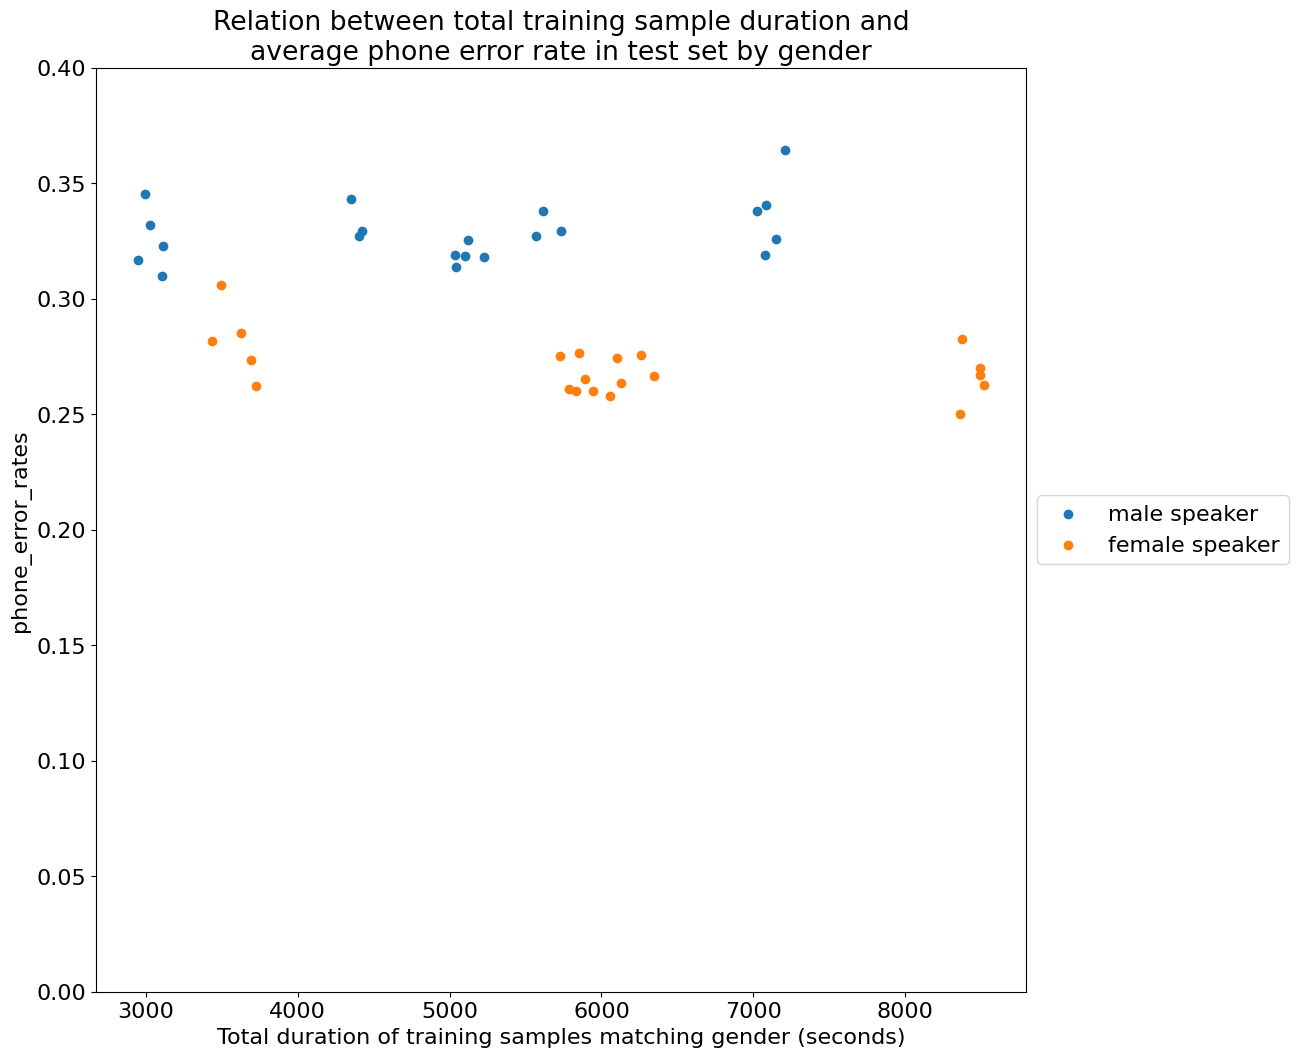

In [18]:
scatter_plot_gender_duration_metric(male_metrics_trained_models, female_metrics_trained_models, male_speaker_duration, female_speaker_duration,
    "Relation between total training sample duration and\naverage phone error rate in test set by gender", "phone_error_rates")

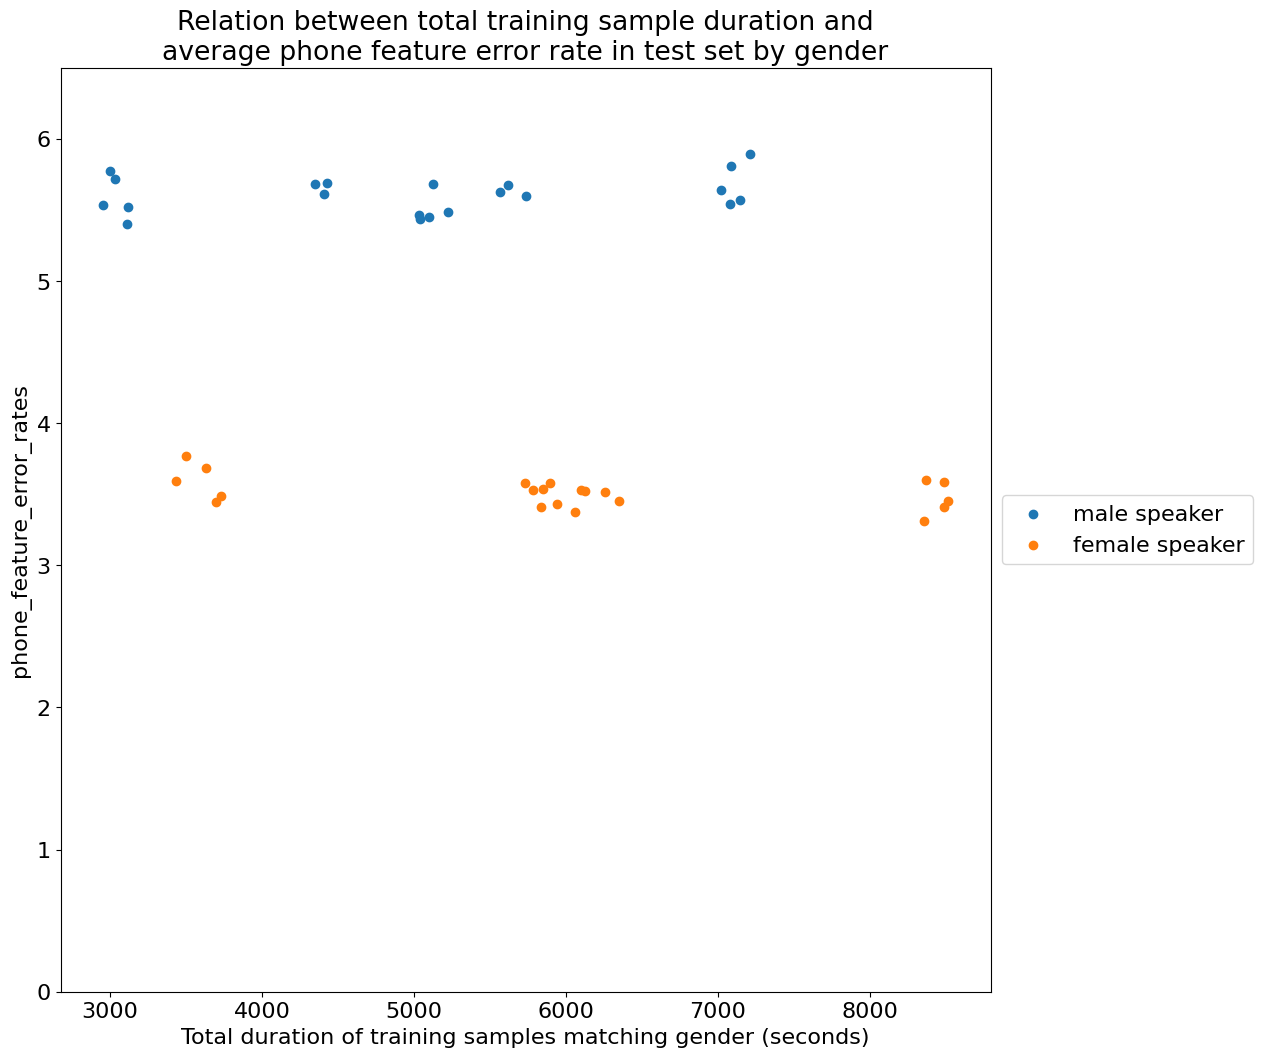

In [19]:
scatter_plot_gender_duration_metric(male_metrics_trained_models, female_metrics_trained_models, male_speaker_duration, female_speaker_duration,
    "Relation between total training sample duration and\naverage phone feature error rate in test set by gender", "phone_feature_error_rates")

In [38]:
def scatter_plot_model_breakdown(male_metrics, female_metrics, male_duration, female_duration, models, title, metric):
    model_groups = set([m[:-2] for m in models])
    colors = sns.hls_palette(len(model_groups))

    color_map = dict(zip(model_groups, colors))

    fig, ax = plt.subplots(figsize=(12,8), layout="constrained")
    lines_for_legend = []
    labels_for_legend = []
    for i, model in enumerate(models):
        model_group = model[:-2]
        color = color_map[model_group]
        male_line = ax.scatter(male_duration[i], male_metrics[metric][i], c=color, marker="x", label=model_group)
        legend_line = ax.scatter(female_duration[i], female_metrics[metric][i], c=color, label=model_group)
        if model_group not in labels_for_legend:
            lines_for_legend.append(legend_line)
            labels_for_legend.append(model_group)

    if metric=="phone_error_rates":
        plt.ylim([0,0.4])
        plt.ylabel("Average Phone Error Rate")
    elif metric=="phone_feature_error_rates":
        plt.ylim([0, 6.5])
        plt.ylabel("Average Phone Feature Error Rate")
    plt.xlabel("Total duration of training samples matching gender (seconds)")
    plt.title(title)
    # Add model groups to legend
    fig.legend(handles=lines_for_legend, bbox_to_anchor=(1.35, 0.5)) #loc='outside right upper')
    # Add gender groups to legend
    fig.legend([male_line, legend_line], ["male speaker", "female speaker"], bbox_to_anchor=(1.25, 0.7)) #loc="outside right center")


/tmp/ipykernel_3289550/1793133101.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  male_line = ax.scatter(male_duration[i], male_metrics[metric][i], c=color, marker="x", label=model_group)
/tmp/ipykernel_3289550/1793133101.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  legend_line = ax.scatter(female_duration[i], female_metrics[metric][i], c=color, label=model_group)


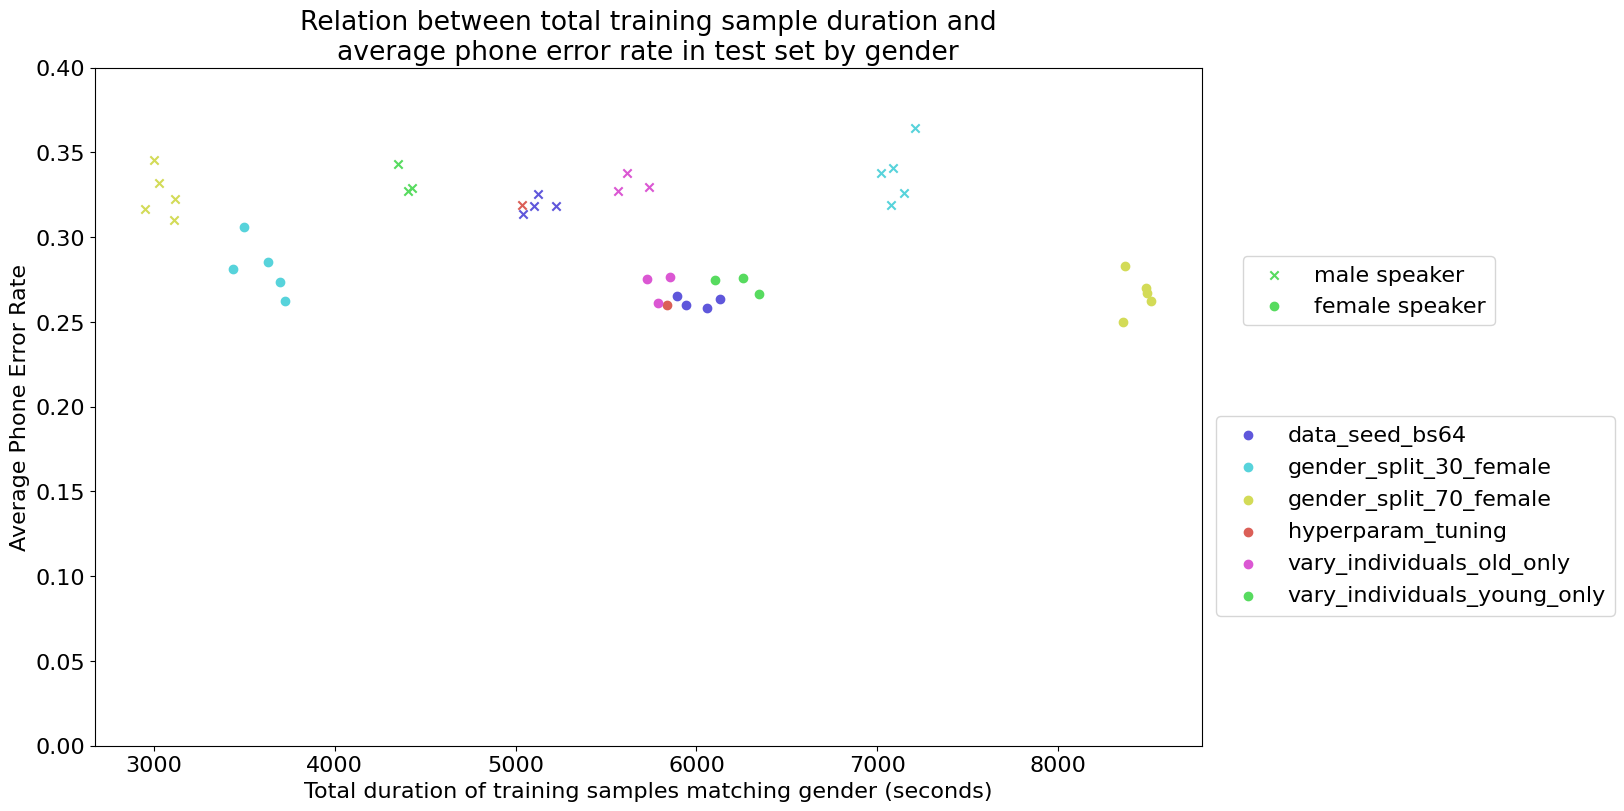

In [39]:
scatter_plot_model_breakdown(male_metrics_trained_models, female_metrics_trained_models, male_speaker_duration, female_speaker_duration, trained_models,
    "Relation between total training sample duration and\naverage phone error rate in test set by gender", "phone_error_rates")

/tmp/ipykernel_3289550/4080978647.py:13: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  male_line = ax.scatter(male_duration[i], male_metrics[metric][i], c=color, marker="x", label=model_group)
/tmp/ipykernel_3289550/4080978647.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  legend_line = ax.scatter(female_duration[i], female_metrics[metric][i], c=color, label=model_group)


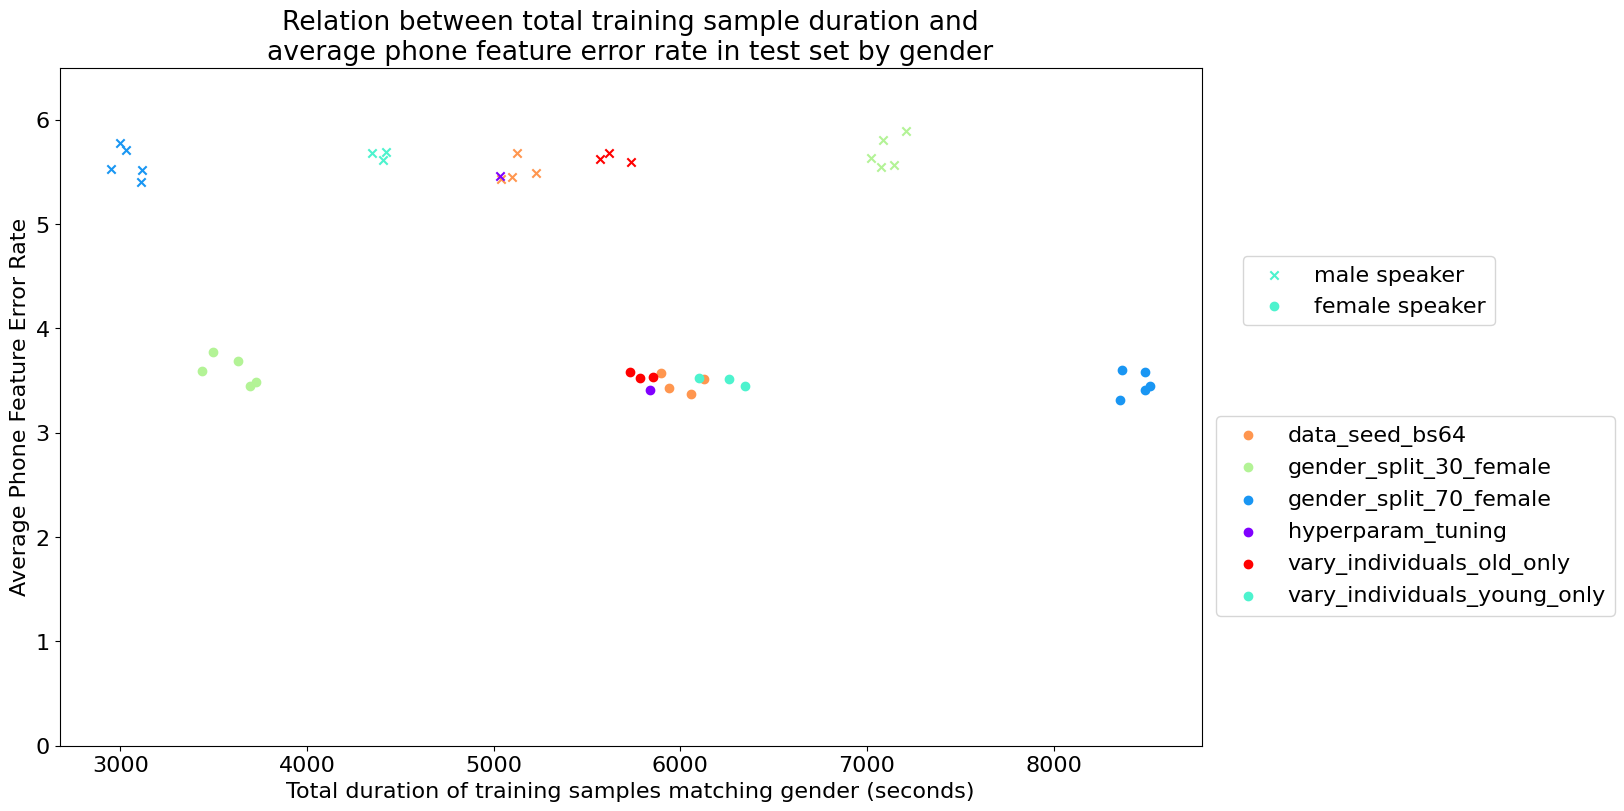

In [29]:
scatter_plot_model_breakdown(male_metrics_trained_models, female_metrics_trained_models, male_speaker_duration, female_speaker_duration, trained_models,
    "Relation between total training sample duration and\naverage phone feature error rate in test set by gender", "phone_feature_error_rates")

# Differences in performance by speaker age group
All the models had better performance (lower error rates) for speakers older than 40 compared to speakers younger than 30 in the test set. This is true even in the 'vary_individuals_old_only' and 'vary_individuals_young_only' models, where only speakers from one age group were allowed to appear in the training data. This does not hold for external models, where there is very little difference between performance on older and younger speakers and in some cases performance is better on younger speakers (i.e. the Taguchi and Whisper medium English models).

Again, it's not clear whether these differences are statistically significant, although they do seem systematic. 

In [23]:
age_groups_metrics, models = stratify_mean_by_experiment_group_and_demographic(all_data, demo_key="speaker_age_range")
print(age_groups_metrics)
print(models)

defaultdict(<function stratify_mean_by_experiment_group_and_demographic.<locals>.<lambda> at 0x786d78161940>, {'o': defaultdict(<class 'list'>, {'phone_error_rates': [np.float64(0.6522066163521482), np.float64(0.8139653736891533), np.float64(0.25892386061767525), np.float64(0.25970740622225197), np.float64(0.2541194843716221), np.float64(0.2519980217143587), np.float64(0.7014476661277553), np.float64(0.6076041891978902), np.float64(0.6164262030348687), np.float64(0.28445451299209146), np.float64(0.31874057590112764), np.float64(0.26749025429905277), np.float64(0.25781398381152754), np.float64(0.28584038574293025), np.float64(0.2579508755204154), np.float64(0.24972493090484313), np.float64(0.26386703835791203), np.float64(0.285719908458292), np.float64(0.2697204900979696), np.float64(0.25321387107846904), np.float64(0.5572189877138528), np.float64(0.5643351289629218), np.float64(0.5741708753991521), np.float64(0.25490846983931587), np.float64(0.2779968030191734), np.float64(0.2733926003

In [24]:
# Check that these are all the same length to make sure we parsed data correctly
assert len(age_groups_metrics['o']['phone_error_rates']) == len(age_groups_metrics['y']['phone_error_rates'])
assert len(age_groups_metrics['y']['phone_error_rates']) == len(models)

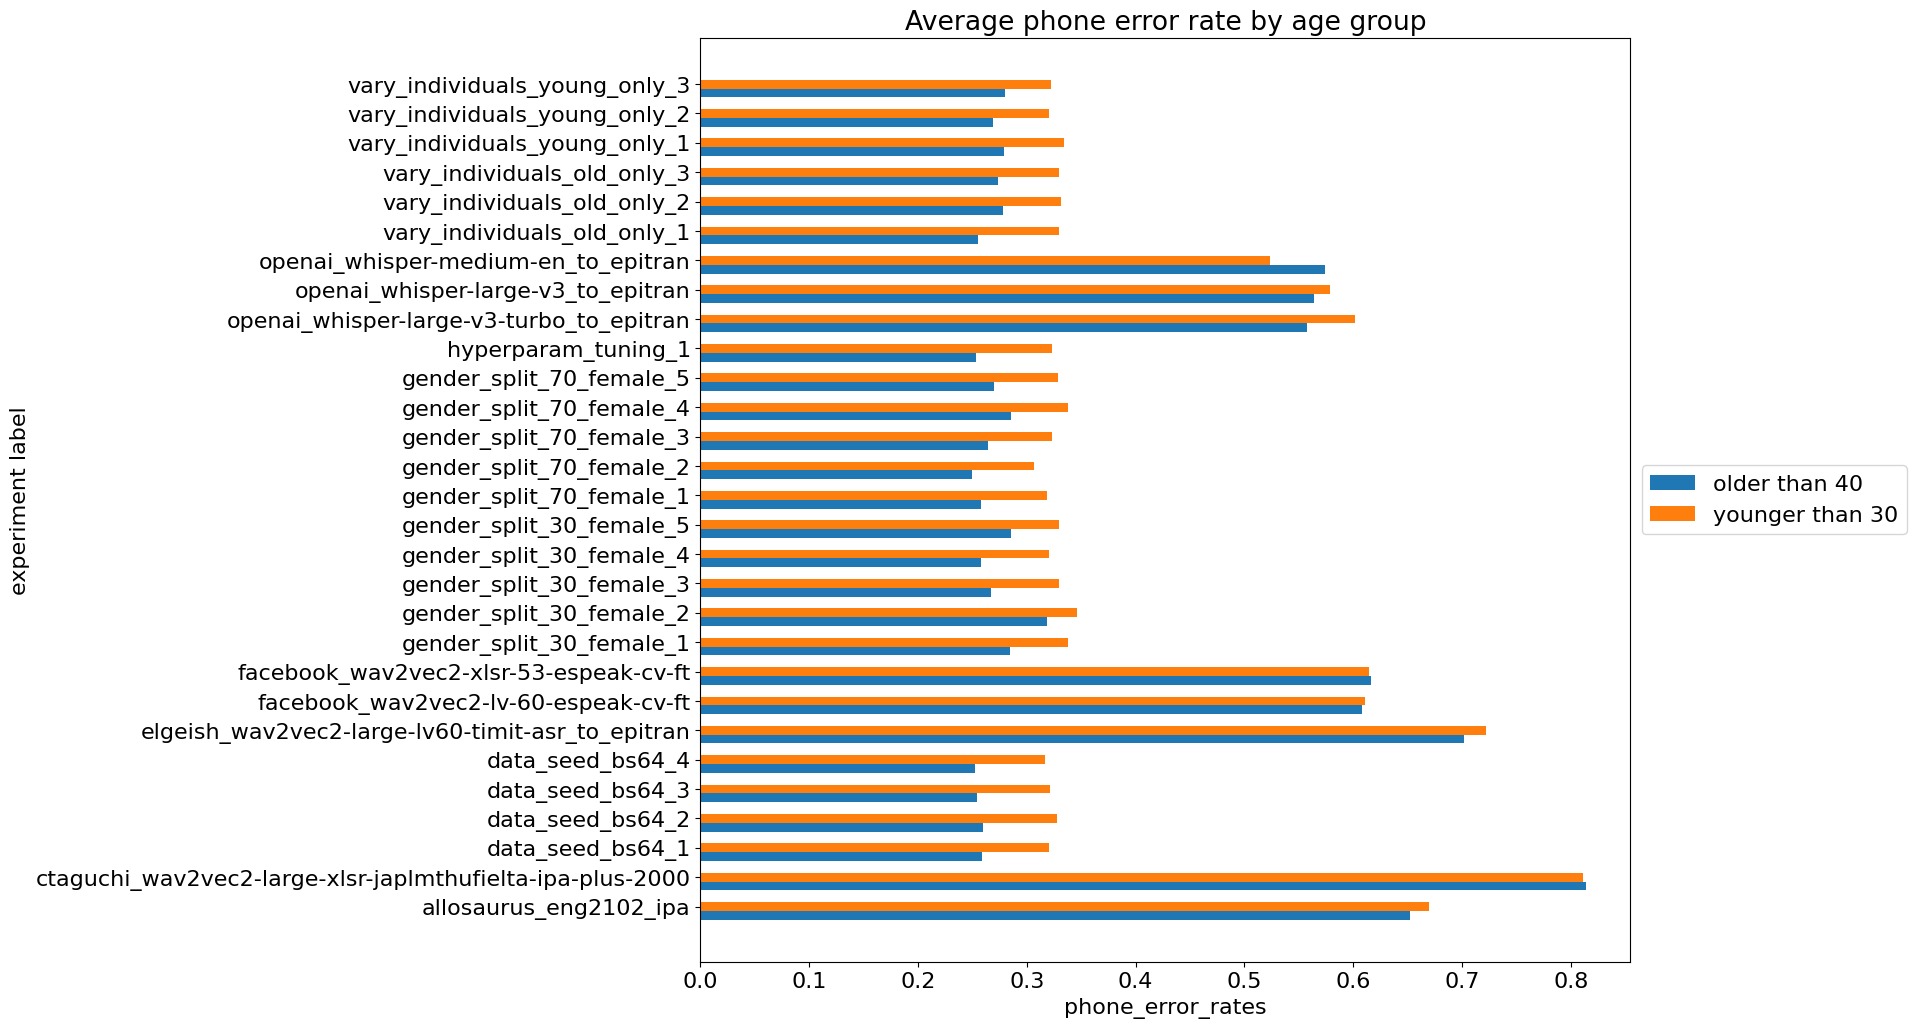

In [25]:
plot_binary_category_grouped_metrics(models, age_groups_metrics['o'], age_groups_metrics['y'], title="Average phone error rate by age group",
    category1_label="older than 40", category2_label="younger than 30")

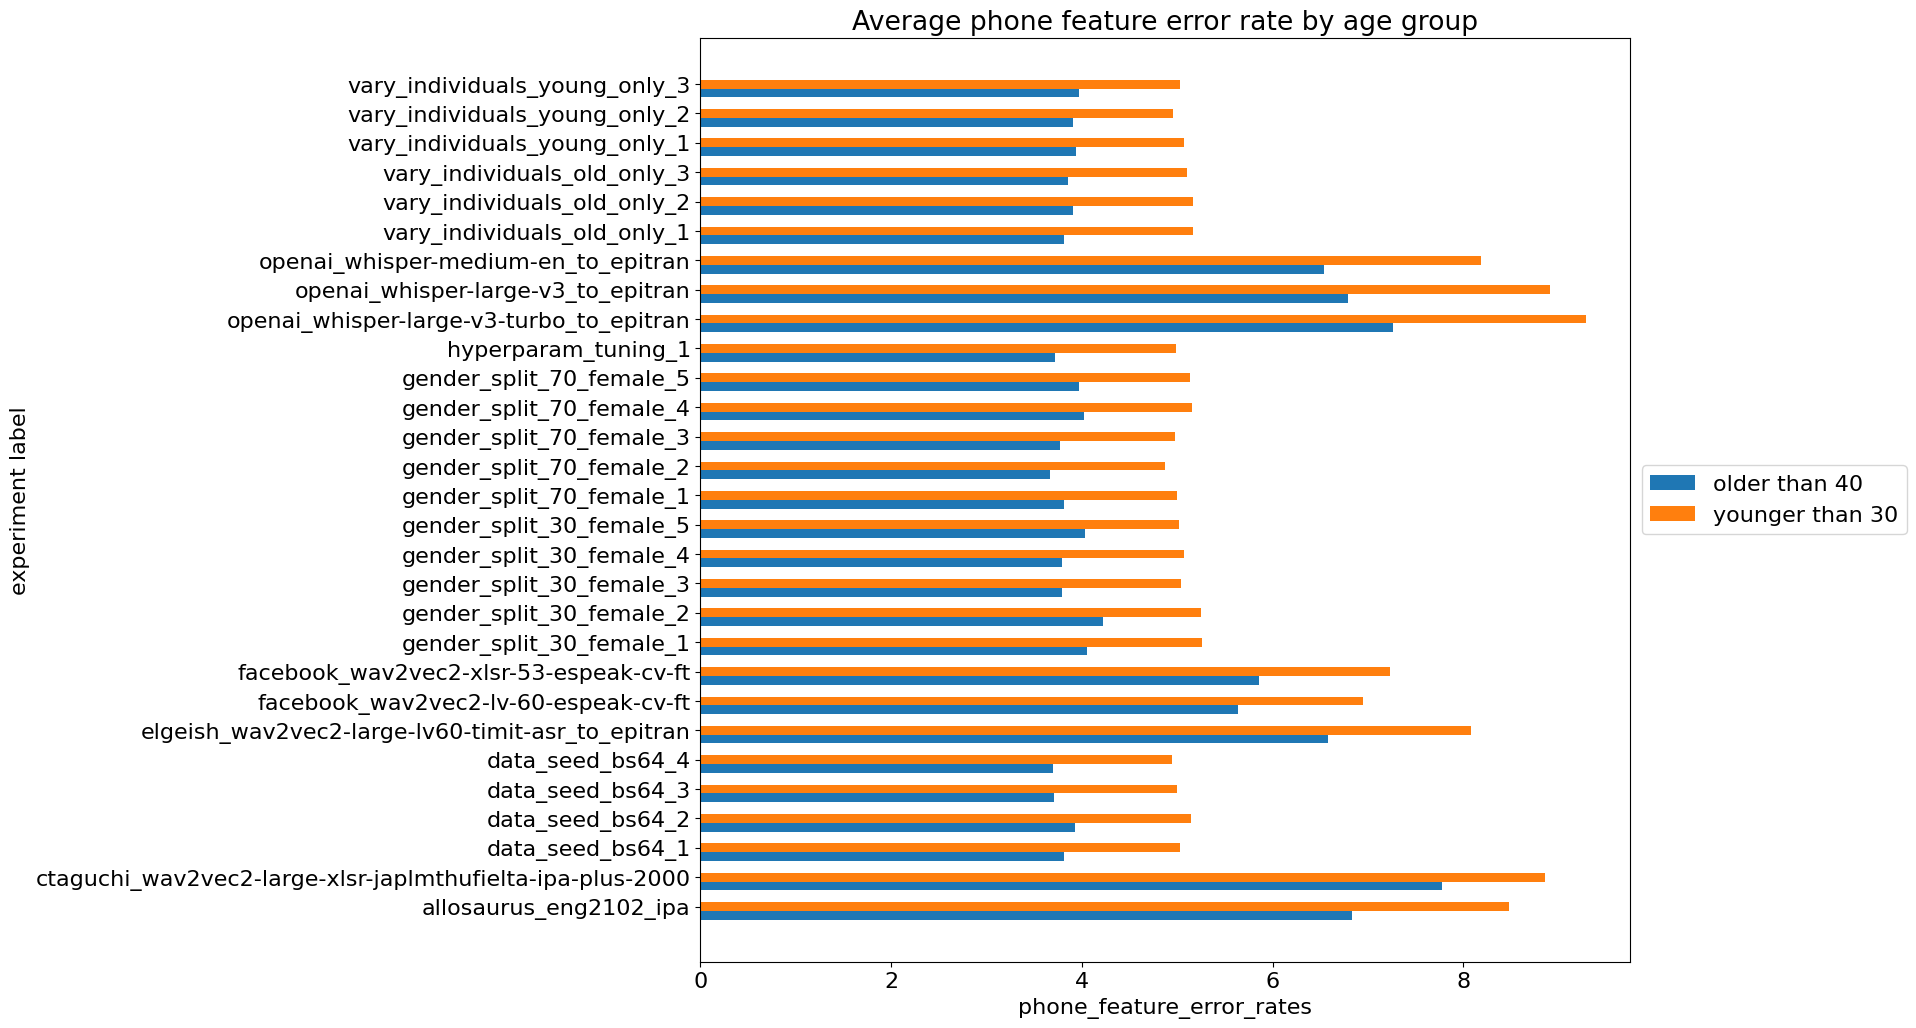

In [26]:
plot_binary_category_grouped_metrics(models, age_groups_metrics['o'], age_groups_metrics['y'], title="Average phone feature error rate by age group",
    category1_label="older than 40", category2_label="younger than 30", metric_name="phone_feature_error_rates")